In [11]:
import numpy as np
import pandas as pd
import torch
import haversine as hs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import *

#### Duplicates

In [205]:
df = pd.read_pickle("data/df_gesamt_15_08_prepocessed_einworner_added.pkl")

In [206]:
df.Breite = np.round(df.Breite.values, decimals=6)

In [207]:
df_2018 = df[df.GJ == 2018].copy()
df_2019 = df[df.GJ == 2019].copy()
df_2022 = df[df.GJ == 2022].copy()
df_2023 = df[df.GJ == 2023].copy()

In [208]:
frames = [
    df_2018[df_2018.duplicated(subset=["Laenge", "Breite"], keep=False)],
    df_2019[df_2019.duplicated(subset=["Laenge", "Breite"], keep=False)],
    df_2022[df_2022.duplicated(subset=["Laenge", "Breite"], keep=False)],
    df_2023[df_2023.duplicated(subset=["Laenge", "Breite"], keep=False)],
]

In [209]:
duplicates_count_2018 = df_2018.duplicated(
    subset=["Laenge", "Breite"], keep=False
).sum()
duplicates_count_2019 = df_2019.duplicated(
    subset=["Laenge", "Breite"], keep=False
).sum()
duplicates_count_2022 = df_2022.duplicated(
    subset=["Laenge", "Breite"], keep=False
).sum()
duplicates_count_2023 = df_2023.duplicated(
    subset=["Laenge", "Breite"], keep=False
).sum()
duplicates_count_2018, duplicates_count_2019, duplicates_count_2022, duplicates_count_2023

(19641, 20901, 23818, 26361)

In [210]:
def duplicates(df_):
    return df_.duplicated(subset=["Laenge", "Breite"], keep=False).sum()

In [211]:
{
    2018: duplicates(df_2018),
    2019: duplicates(df_2019),
    2022: duplicates(df_2022),
    2023: duplicates(df_2023),
}

{2018: 19641, 2019: 20901, 2022: 23818, 2023: 26361}

#### Calculate distances

In [29]:
# # haversine distance calculator function


def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth.

    Parameters:
    - lat1 Laenge1 (float): Latitude of the first point in degrees.
    - lon1 Breite1 (float): Longitude of the first point in degrees.
    - lat2 Laenge2 (float): Latitude of the second point in degrees.
    - lon2 Breite2 (float): Longitude of the second point in degrees.

    Returns:
    - float: Distance between the two points in meters.

    Note:
    This function assumes the Earth is a perfect sphere with a radius of 6,371,000 meters.
    """

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Radius of Earth in kilometers
    r = 6371.0
    return r * c

#### Neighbors count

In [213]:
def neighbors_count(year=None, max_count=True):
    """
    This function return the max count of neighbors for each year, or if you select the year, the neighbors or max count

    """
    neighbors = {}

    if year:
        try:
            neighbor_by_year = (
                pd.read_csv(f"./data/distances_{year}.csv")
                .groupby("Qid1")["Qid2"]
                .agg(list)
                .apply(len)
                .sort_values(ascending=True)
            )
            return neighbor_by_year.max() if max_count else neighbor_by_year
        except:
            print(f"No data found for the year {year}")

    for i in range(2018, 2024):
        if i not in (2020, 2021):
            neighbors[i] = (
                pd.read_csv(f"./data/distances_{i}.csv")
                .groupby("Qid1")["Qid2"]
                .agg(list)
                .apply(len)
                .max()
            )
    return neighbors

In [214]:
# neighbors_count(2023, max_count=False),neighbors_count()

#### Binary decoding cities' names

In [215]:
from tqdm import tqdm


def binary_decode(encoded_data, label_mapping=None):
    l = []
    if label_mapping == None:
        label_mapping = {
            k: v
            for v, k in enumerate(
                pd.read_pickle("./data/df_gesamt_upd.pkl")["Ort"].unique()
            )
        }

    for j in range(encoded_data.shape[0]):
        binary_string = "".join(
            str(int(encoded_data[f"c_name{i}"].iloc[j])) for i in range(1, 14)
        )

        # Convert binary string to integer
        decoded_int = int(binary_string, 2)

        # Reverse the label mapping to get the original city name
        reverse_label_mapping = {v: k for k, v in label_mapping.items()}
        decoded_city_name = reverse_label_mapping.get(decoded_int, "Unknown")
        l.append(decoded_city_name)
    encoded_data["Ort"] = l


# binary_decode(d,label_mapping)

#### Neighbors in 200 meters (top 10)

In [217]:
def takeTopNeighbours(df, qid, top=10, shuffle=False):
    current_data = df[df.Qid1 == qid]
    sorted_data = current_data.sort_values(by="distance")
    self_pair = sorted_data[sorted_data.Qid2 == qid]

    if not self_pair.empty:
        sorted_data = sorted_data[sorted_data.Qid2 != qid].iloc[: top - 1]
        if shuffle:
            sorted_data = sorted_data.sample(n=sorted_data.shape[0], ignore_index=True)
        sorted_data = pd.concat([self_pair, sorted_data], ignore_index=True)
    elif self_pair.shape[0] == 1:
        sorted_data = self_pair

    return sorted_data.Qid2.values

In [218]:
takeTopNeighbours(distance_2019, 5004)

array([5004.])

#### Plots

In [ ]:
# label_mapping = {k: v for v, k in enumerate(pd.read_pickle('./data/old_data/df_gesamt_upd.pkl')['Ort'].unique())}
# binary_decode(df, label_mapping=label_mapping)

In [ ]:
city = df.Ort == "Essen"

In [ ]:
city.sum()

In [ ]:
add1 = df[city & (df.Qid == 16326)].iloc[0]
add2 = df[city & (df.Qid == 29485.0)].iloc[0]
add3 = df[city & (df.Qid == 9333.0)].iloc[0]
add4 = df[city & (df.Qid == 24665.0)].iloc[0]
add5 = df[city & (df.Qid == 9600.0)].iloc[0]
add6 = df[city & (df.Qid == 761666.0)].iloc[0]
add7 = df[city & (df.Qid == 9745.0)].iloc[0]

In [ ]:
selected_qids = np.array([16326, 29485, 9333, 24665, 9600, 761666, 9745])

In [ ]:
region = (
    df["PLZ"]
    .astype(str)
    .apply(lambda x: "0" if x == "nan" else x)
    .apply(lambda x: x[:3])
    .astype(float)
    .astype(int)
)

In [ ]:
plt.figure(figsize=(10, 10))
labels = [f"Qid_{i}" for i in selected_qids]
adds = [add1, add2, add3, add4, add5, add6, add7]
plt.scatter(
    df[df.Ort == "Essen"]["Laenge"],
    df[df.Ort == "Essen"]["Breite"],
    c="gray",
    cmap="magma",
)
colors = [
    "red",
    "blue",
    "darkgreen",
    "darkorange",
    "rebeccapurple",
    "olivedrab",
    "teal",
]
for i, add in enumerate(adds):
    plt.scatter(add["Laenge"], add["Breite"], c=colors[i], cmap="magma")
    plt.annotate(
        labels[i],
        (add["Laenge"], add["Breite"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        c=colors[i],
        bbox=dict(facecolor="white", edgecolor="none", pad=0),
    )
plt.axis("equal")
plt.show()

#### Selected qids


In [ ]:
qids = [9860, 9673, 9855, 9333]

In [ ]:
qid_9860 = df[city & (df.Qid == 9860)].iloc[0]
qid_9673 = df[city & (df.Qid == 9673)].iloc[0]
qid_9855 = df[city & (df.Qid == 9855)].iloc[0]
qid_9333 = df[city & (df.Qid == 9333)].iloc[0]

In [ ]:
# haversine_distance(*df[df.Qid.isin(qids)][['Breite', 'Laenge']].values.T,*df[df.Qid.isin(qids)][['Breite', 'Laenge']].values.T)

In [ ]:
city = df.Ort == "Essen"

In [75]:
plt.figure(figsize=(10, 10))
labels = [f"Qid={i}" for i in qids]
adds = [qid_9860, qid_9673, qid_9855, qid_9333]
plt.scatter(
    df[df.Ort == "Essen"]["Laenge"],
    df[df.Ort == "Essen"]["Breite"],
    c="gray",
    cmap="magma",
)
colors = [
    "red",
    "blue",
    "darkorange",
    "darkgreen",
    "rebeccapurple",
    "olivedrab",
    "teal",
]

for i, add in enumerate(adds):
    plt.scatter(add["Laenge"], add["Breite"], c=colors[i], cmap="magma")
    plt.annotate(
        labels[i],
        (add["Laenge"], add["Breite"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        c=colors[i],
        bbox=dict(facecolor="white", edgecolor="none", pad=0),
    )

plt.axis("equal")
plt.show()

NameError: name 'df' is not defined

<Figure size 1000x1000 with 0 Axes>

In [ ]:
loader = CustomDataLoader()

In [ ]:
X_train, X_val, y_train, y_val = loader.loader()

In [ ]:
X_train.shape, X_val.shape

In [ ]:
torch.save(X_train, "data/selected_qids.pt")

#### Price distribution 

In [ ]:
years = [2018, 2019, 2022, 2023]
colors = ["blue", "yellow", "red", "green"]
labels = [str(year) for year in years]

plt.figure(figsize=(8, 6))

for year, color, label in zip(years, colors, labels):
    prices = df[df.GJ == year]["Preis"]
    plt.hist(prices, bins=20, density=True, alpha=0.7, color=color, label=label)

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Distribution of Price")
plt.legend()
plt.show()

#### Augmentation

In [ ]:
df = pd.read_pickle("data/df_gesamt_prepocessed_reordered.pkl")

In [ ]:
def augmentation(data, size=0.1, k_factor=2):
    size = int(data.shape[0] * size / 4)
    decades = [f"T{i}" for i in range(1, 35)]

    data_2018 = (
        data[data.GJ == 2018]
        .copy()
        .sample(n=size, random_state=42)
        .sort_values(by="Qid")
    )
    data_2019 = (
        data[data.GJ == 2019]
        .copy()
        .sample(n=size, random_state=42)
        .sort_values(by="Qid")
    )
    data_2022 = (
        data[data.GJ == 2022]
        .copy()
        .sample(n=size, random_state=42)
        .sort_values(by="Qid")
    )
    data_2023 = (
        data[data.GJ == 2023]
        .copy()
        .sample(n=size, random_state=42)
        .sort_values(by="Qid")
    )

    years = [data_2018, data_2019, data_2022, data_2023]

    for year in years:
        year["Preis"] = (
            data[data.Qid.isin(year.Qid)].groupby("Qid")["Preis"].apply(max).values
        )
        year["Qid"] += 0.1
        year[decades] = 0

    augmented_data = pd.concat(
        [data, data_2018, data_2019, data_2022, data_2023], ignore_index=True
    )
    return augmented_data

In [ ]:
augm = augmentation(df)

In [35]:
tensor = torch.zeros(0, 10, 78) 
tensor1 = torch.rand(10, 78)
tensor = torch.cat([tensor, tensor1[None]], dim=0)
tensor.shape

torch.Size([1, 10, 78])

#### New data architecture

In [ ]:
data = pd.read_pickle("data/df_gesamt_10_08_prepocessed.pkl")

In [ ]:
class CustomDataLoader2:
    def __init__(
        self, data_path="./data/df_gesamt_10_08_prepocessed.pkl", test_size=0.05
    ):
        self.data = pd.read_pickle(data_path).reset_index(drop=True)

        # Normalize the columns
        self.data.Laenge = self.min_max_norm(self.data.Laenge, -180, +180)
        self.data.Breite = self.min_max_norm(self.data.Breite, -90, +90)
        self.data.PPSVACWert = self.gaussian_norm(self.data.PPSVACWert)

        # Train / Val split
        self.Qid_train, self.Qid_val = train_test_split(
            self.data["Qid"].unique(), test_size=test_size, random_state=23
        )

        # Load distances
        self.distances_2018 = pd.read_csv("data/distances/distances_2018.csv")
        self.distances_2019 = pd.read_csv("data/distances/distances_2019.csv")
        self.distances_2020 = pd.read_csv("data/distances/distances_2020.csv")
        self.distances_2021 = pd.read_csv("data/distances/distances_2021.csv")
        self.distances_2022 = pd.read_csv("data/distances/distances_2022.csv")
        self.distances_2023 = pd.read_csv("data/distances/distances_2023.csv")

        self.decades = pd.read_csv("./data/decades.csv")

        self.data_2023 = self.data[self.data.GJ == 2023].copy()

        # define constants
        self.CHUNK_SIZE = 20_000
        self.MAX_NEIGHBOURS_SIZE = 10
        self.DECADE_WINDOWS_SIZE = 3
        self.NUM_DECADES = 34 * (self.data.GJ.unique().shape[0] - 1)
        self.DECADE_COLUMN_SLICES = [
            [f"T{i}" for i in range(k, k + self.DECADE_WINDOWS_SIZE)]
            for k in range(1, self.NUM_DECADES - self.DECADE_WINDOWS_SIZE + 2)
        ]
        self.CONST_COLUMNS = [
            "Stellensubart_0",
            "Stellensubart_1",
            "Stellensubart_2",
            "Stellensubart_3",
            "Stellensubart_4",
            "Stellensubart_5",
            "Stellensubart_6",
            "Stellensubart_7",
            "Stellensubart_8",
            "Stellensubart_9",
            "Stellensubart_10",
            "Stellensubart_11",
            "Stellensubart_12",
            "Stellensubart_13",
            "Stellensubart_14",
            "Preis",
            "Beleuchtet",
            "Laenge",
            "Breite",
            "Eigenfläche",
            "PPSVACWert",
        ]

    def min_max_norm(self, x, min_, max_):
        x_norm = (x - min_) / (max_ - min_)
        return x_norm

    def gaussian_norm(self, x):
        x_norm = (x - x.mean()) / x.std()

        return x_norm

    def load_and_save(self):
        train_chunks = torch.split(torch.tensor(self.Qid_train), self.CHUNK_SIZE)

        for i, chunk in enumerate(tqdm(train_chunks, position=0, leave=True)):
            X, y = self.load(chunk.numpy())

            torch.save(X, f"./data/saved_train_val_data/X_train_{i}.pt")
            torch.save(y, f"./data/saved_train_val_data/y_train_{i}.pt")

            del X, y

        X, y = self.load(self.Qid_val)
        #         torch.save(X, f"./data/saved_train_val_data/X_val.pt")
        #         torch.save(y, f"./data/saved_train_val_data/y_val.pt")

        del X, y

    def load(self, qid_chunks):
        X, y = [], []

        for qid in tqdm(qid_chunks, position=0, leave=True):
            qid2_2018 = self.takeTopNeighbours(self.distances_2018, qid)
            qid2_2019 = self.takeTopNeighbours(self.distances_2019, qid)
            qid2_2020 = self.takeTopNeighbours(self.distances_2020, qid)
            qid2_2021 = self.takeTopNeighbours(self.distances_2021, qid)
            qid2_2022 = self.takeTopNeighbours(self.distances_2022, qid)
            print(qid, qid2_2018, qid2_2019, qid2_2020, qid2_2021, qid2_2022)
            qid_complete_T = pd.concat(
                [
                    self.decades[self.decades.Qid.isin(qid2_2018)]
                    .loc[:, "T1":"T34"]
                    .reset_index(drop=True),
                    self.decades[self.decades.Qid.isin(qid2_2019)]
                    .loc[:, "T35":"T68"]
                    .reset_index(drop=True),
                    self.decades[self.decades.Qid.isin(qid2_2020)]
                    .loc[:, "T69":"T102"]
                    .reset_index(drop=True),
                    self.decades[self.decades.Qid.isin(qid2_2021)]
                    .loc[:, "T103":"T136"]
                    .reset_index(drop=True),
                    self.decades[self.decades.Qid.isin(qid2_2022)]
                    .loc[:, "T137":"T170"]
                    .reset_index(drop=True),
                ],
                axis=1,
                ignore_index=True,
            ).fillna(-1)

            qid_complete_T.columns = [f"T{i}" for i in range(1, self.NUM_DECADES + 1)]
            print(qid_complete_T.shape)
            currData = self.takeByQid(
                qid,
                qid_complete_T,
                qid2_2018,
                qid2_2019,
                qid2_2020,
                qid2_2021,
                qid2_2022,
            )
            print(currData.shape)
            X.append(currData)
            y.append(self.takeTarget(qid))

        return torch.stack(X, dim=0), torch.stack(y, dim=0)

    def pad_to_size(self, tensor):
        # Check if the tensor is 2D
        if len(tensor.shape) != 2:
            raise ValueError("Input tensor should be 2D")

        current_x, current_y = tensor.shape
        pad_left = 0
        pad_right = 0
        pad_top = 0
        pad_bottom = max(0, self.MAX_NEIGHBOURS_SIZE - current_x)

        return torch.nn.functional.pad(
            tensor, (pad_left, pad_right, pad_top, pad_bottom), "constant", -1
        )

    def takeTarget(self, qid):
        targetRows = self.data_2023[self.data_2023.Qid == qid].copy()

        if targetRows.shape[0]:
            T = targetRows.loc[:, "T1":"T22"].copy()
            T[T == -1] = 0  # TODO: check later
            meanOf_T = T.mean().mean()
            return torch.tensor([meanOf_T])

        return torch.tensor([0.0])

    def takeConstPart(self, qids, year):
        # TODO: check the case when there is no `year` data for that Qid

        data_part = self.data[self.data["GJ"] == year]
        one_year_data = data_part[data_part.Qid.isin(qids)]

        if one_year_data.shape[0]:
            one_year_data = one_year_data.loc[:, self.CONST_COLUMNS].copy()
            one_year_data = torch.tensor(one_year_data.astype(float).values)

            # TODO: add pad_to_size
            return self.pad_to_size(one_year_data)
        else:
            return -torch.ones(self.MAX_NEIGHBOURS_SIZE, len(self.CONST_COLUMNS))

    def get2023data(self, qid):
        # TODO: check the case when there is no 2023 data for that Qid

        data_part_2023 = self.data_2023[self.data_2023.Qid == qid]

        if data_part_2023.shape[0]:
            data_part_2023 = data_part_2023.loc[:, self.CONST_COLUMNS].copy()
            data_part_2023["PPSVACWert"] = -1  # TODO: check later.
            data_part_2023 = torch.tensor(data_part_2023.astype(float).values)
            data_part_2023 = data_part_2023.repeat(10, 1)
            return data_part_2023

        else:
            return -torch.ones(self.MAX_NEIGHBOURS_SIZE, len(self.CONST_COLUMNS))

    def get_year(self, index):
        if index <= 34:
            return 2018
        elif index <= 68:
            return 2019
        elif index <= 102:
            return 2020
        elif index <= 136:
            return 2021
        else:
            return 2022

    def takeByQid(
        self, qid, decades, qid2_2018, qid2_2019, qid2_2020, qid2_2021, qid2_2022
    ):
        data_part_2018 = self.takeConstPart(qid2_2018, 2018)
        data_part_2019 = self.takeConstPart(qid2_2019, 2019)
        data_part_2020 = self.takeConstPart(qid2_2020, 2020)
        data_part_2021 = self.takeConstPart(qid2_2021, 2021)
        data_part_2022 = self.takeConstPart(qid2_2022, 2022)
        data_part_2023 = self.get2023data(qid)

        choice = {
            2018: data_part_2018,
            2019: data_part_2019,
            2020: data_part_2020,
            2021: data_part_2021,
            2022: data_part_2022,
        }

        return_value = []

        for decade_columns in self.DECADE_COLUMN_SLICES:
            decade_slice = decades.loc[:, decade_columns].copy()
            decade_slice = torch.tensor(decade_slice.astype(float).values)

            # TODO: check the case when there is no 10 neighbours

            if decade_slice.shape[0] != self.MAX_NEIGHBOURS_SIZE:
                decade_slice = self.pad_to_size(decade_slice)

            current_sequence = [decade_slice]

            for column in decade_columns:
                index = int(column[1:])
                year = self.get_year(index)
                current_sequence.extend([choice[year], data_part_2023])

            current_sequence = torch.cat(current_sequence, dim=-1)

            return_value.append(current_sequence)

        return torch.stack(return_value, dim=0)

    def takeTopNeighbours(self, df, qid, top=10):
        current_data = df[df.Qid1 == qid]
        sorted_data = current_data.sort_values(by="distance")
        self_pair = sorted_data[sorted_data.Qid2 == qid]

        if not self_pair.empty and self_pair.shape[1] > 1:
            sorted_data = sorted_data[sorted_data.Qid2 != qid]
            sorted_data = pd.concat([self_pair, sorted_data], ignore_index=True)

        elif self_pair.shape[0] == 1:
            sorted_data = self_pair

        return sorted_data.iloc[:top].Qid2.values

In [ ]:
loader = CustomDataLoader2()

In [ ]:
loader.load_and_save()

In [ ]:
takeTopNeighbours(pd.read_csv("data/distances/distances_2023.csv"), 899114.0)

#### Data architecture with shuffled neighbors

In [ ]:
class CustomDataLoader:
    def __init__(self, test_size=0.05):
        """
        The Dataloader returns a tensor with a shape of [N, yearsCount, MAX_NEIGHBOURS_SIZE, FEATURES_COUNT],
        with shuffled neighbors.

        """
        self.MAX_NEIGHBOURS_SIZE = 10
        self.fillingValueForPadding = -1
        self.yearsCount = 6
        self.listOfT = [f"T{i+1}" for i in range(34)]
        self.CONST_COLUMNS = [
            "Stellensubart_1",
            "Stellensubart_2",
            "Stellensubart_3",
            "Stellensubart_4",
            "T1",
            "T2",
            "T3",
            "T4",
            "T5",
            "T6",
            "T7",
            "T8",
            "T9",
            "T10",
            "T11",
            "T12",
            "T13",
            "T14",
            "T15",
            "T16",
            "T17",
            "T18",
            "T19",
            "T20",
            "T21",
            "T22",
            "T23",
            "T24",
            "T25",
            "T26",
            "T27",
            "T28",
            "T29",
            "T30",
            "T31",
            "T32",
            "T33",
            "T34",
            #'Einwohner',
            "Preis",
            "Beleuchtet",
            "Laenge",
            "Breite",
            "Eigenfläche",
            "PPSVACWert",
        ]

        self.data = pd.read_pickle(
            "data/df_gesamt_15_08_prepocessed_einworner_added.pkl"
        )
        self.data.reset_index(drop=True, inplace=True)
        self.data.drop(columns=["PLZ", "Ort"], inplace=True)
        self.drop_less_years(self.data)
        self.Qid_train, self.Qid_val = train_test_split(
            self.data["Qid"].unique(), test_size=test_size, random_state=23
        )
        #         self.Qid_train=self.Qid_train[:4]
        #         self.Qid_val=self.Qid_val[:2]
        self.data.Laenge = self.normalize_longitude(self.data.Laenge.values)
        self.data.Breite = self.normalize_latitude(self.data.Breite.values)
        # normalizing columns without last year data
        self.normalize_data(self.data, "PPSVACWert")
        #         self.normalize_min_max(self.data, "Einwohner")

        # splitting data to years
        self.data_2018 = self.data[self.data["GJ"] == 2018].copy()
        self.data_2019 = self.data[self.data["GJ"] == 2019].copy()
        self.data_2020 = self.data[self.data["GJ"] == 2020].copy()
        self.data_2021 = self.data[self.data["GJ"] == 2021].copy()
        self.data_2022 = self.data[self.data["GJ"] == 2022].copy()
        self.data_2023 = self.data[self.data["GJ"] == 2023].copy()

        # dropping unnecessary columns
        self.data.drop(columns=["GJ"], inplace=True)
        self.data_2018.drop(columns=["GJ"], inplace=True)
        self.data_2019.drop(columns=["GJ"], inplace=True)
        self.data_2020.drop(columns=["GJ"], inplace=True)
        self.data_2021.drop(columns=["GJ"], inplace=True)
        self.data_2022.drop(columns=["GJ"], inplace=True)
        self.data_2023.drop(columns=["GJ"], inplace=True)

        self.distances_2018 = pd.read_csv("data/distances/distances_2018.csv")
        self.distances_2019 = pd.read_csv("data/distances/distances_2019.csv")
        self.distances_2020 = pd.read_csv("data/distances/distances_2020.csv")
        self.distances_2021 = pd.read_csv("data/distances/distances_2021.csv")
        self.distances_2022 = pd.read_csv("data/distances/distances_2022.csv")
        self.distances_2023 = pd.read_csv("data/distances/distances_2023.csv")

    def normalize_longitude(self, longitude):
        min_lon = -180.0
        max_lon = 180.0
        normalized_lon = (longitude - min_lon) / (max_lon - min_lon)
        return normalized_lon

    def normalize_latitude(self, latitude):
        min_lat = -90.0
        max_lat = 90.0
        normalized_lat = (latitude - min_lat) / (max_lat - min_lat)
        return normalized_lat

    def normalize_data(self, data, col):
        def mean_std_norm(x):
            return (x - x.mean()) / x.std()

        index = data.index
        data.loc[index, col] = mean_std_norm(data.loc[index, col])

    def normalize_min_max(self, data, col):
        def min_max(x):
            return (x - x.min()) / (x.max() - x.min())

        index = data.index
        data.loc[index, col] = min_max(data.loc[index, col])

    def loader(self):
        train_dataReturn_X, val_dataReturn_X = [], []
        train_dataReturn_Y, val_dataReturn_Y = [], []

        # Define a function to process a single Qid
        def process_qid(qid):
            qid2_2018 = self.takeTopNeighbours(self.distances_2018, qid)
            qid2_2019 = self.takeTopNeighbours(self.distances_2019, qid)
            qid2_2020 = self.takeTopNeighbours(self.distances_2020, qid)
            qid2_2021 = self.takeTopNeighbours(self.distances_2021, qid)
            qid2_2022 = self.takeTopNeighbours(self.distances_2022, qid)

            curr_2018_X = self.takeByQid(self.data_2018, self.distances_2018, qid2_2018)
            curr_2019_X = self.takeByQid(self.data_2019, self.distances_2019, qid2_2019)
            curr_2020_X = self.takeByQid(self.data_2020, self.distances_2020, qid2_2020)
            curr_2021_X = self.takeByQid(self.data_2021, self.distances_2021, qid2_2021)
            curr_2022_X = self.takeByQid(self.data_2022, self.distances_2022, qid2_2022)
            curr_2023_X = self.takeByQidLastYear(self.data_2023, qid)
            currData_X = torch.cat(
                [
                    curr_2018_X,
                    curr_2019_X,
                    curr_2020_X,
                    curr_2021_X,
                    curr_2022_X,
                    curr_2023_X,
                ],
                axis=0,
            )
            currData_Y = self.takeTargetByQid(self.data_2023, qid)

            return currData_X, currData_Y

        for qid in tqdm(self.Qid_train):
            currData_X, currData_Y = process_qid(qid)
            train_dataReturn_X.append(currData_X)
            train_dataReturn_Y.append(currData_Y)

        for qid in tqdm(self.Qid_val):
            currData_X, currData_Y = process_qid(qid)
            val_dataReturn_X.append(currData_X)
            val_dataReturn_Y.append(currData_Y)

        X_train = torch.squeeze(torch.stack(train_dataReturn_X))
        y_train = torch.stack(train_dataReturn_Y)

        X_val = torch.squeeze(torch.stack(val_dataReturn_X))
        y_val = torch.stack(val_dataReturn_Y)

        return X_train, X_val, y_train, y_val

    def takeByQid(self, dataPart, dist, qids):
        currData_X = dataPart[dataPart.Qid.isin(qids)].copy()
        drop_columns = ["Qid"]
        currdata_X = currData_X.loc[:, self.CONST_COLUMNS]
        return self.pad_to_size(torch.tensor(currdata_X.values.astype(float))).permute(
            2, 0, 1
        )

    def takeByQidLastYear(self, dataPart, qid):
        currData = dataPart[dataPart.Qid == qid].copy()
        if currData.shape[0]:
            currData.drop(columns=["Qid"], inplace=True)
            currData = currData.loc[:, self.CONST_COLUMNS]
            currData["PPSVACWert"] = -1
            currData[self.listOfT] = -1
            return self.pad_to_size(
                torch.tensor(currData.astype(float).values)
            ).permute(2, 0, 1)

    def takeTargetByQid(self, dataPart, qid):
        targetRows = dataPart[dataPart.Qid == qid].copy()
        if targetRows.shape[0]:
            T = targetRows.loc[:, "T1":"T22"].copy()
            T[T == -1] = 0
            meanOf_T = T.mean().mean()
            return torch.tensor([meanOf_T])

    def takeTopNeighbours(self, df, qid, top=10):
        current_data = df[df.Qid1 == qid]
        sorted_data = current_data.sort_values(by="distance")
        self_pair = sorted_data[sorted_data.Qid2 == qid]

        if not self_pair.empty:
            sorted_data = sorted_data[sorted_data.Qid2 != qid].iloc[: top - 1]
            sorted_data = sorted_data.sample(n=sorted_data.shape[0], ignore_index=True)
            sorted_data = pd.concat([self_pair, sorted_data], ignore_index=True)
        elif self_pair.shape[0] == 1:
            sorted_data = self_pair

        return sorted_data.Qid2.values

    def pad_to_size(self, tensor):
        # Check if the tensor is 2D
        if len(tensor.shape) != 2:
            raise ValueError("Input tensor should be 2D")

        current_x, current_y = tensor.shape
        pad_left = 0
        pad_right = 0
        pad_top = 0
        pad_bottom = max(0, self.MAX_NEIGHBOURS_SIZE - current_x)

        return torch.nn.functional.pad(
            tensor,
            (pad_left, pad_right, pad_top, pad_bottom),
            "constant",
            self.fillingValueForPadding,
        )[..., None]

    def drop_less_years(self, data):
        mask = (
            data.groupby(["Qid"])[["GJ"]].transform("count") < self.yearsCount
        ).values
        data.drop(index=data[mask].index, inplace=True)

In [ ]:
loader = CustomDataLoader()

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_x, path_y, p=0.1):
        self.data_x = torch.load(path_x)
        self.data_y = torch.load(path_y)
        self.p = p

    def __getitem__(self, index):
        tmp = self.data_x[index].clone()

        if torch.rand(1) < self.p:
            return self._transform(tmp, self.data_y[index].clone())
        else:
            return tmp, self.data_y[index]

    def _transform(self, data_x, data_y, k_factor=2):
        maxPrice = max(data_x[[0, 31, 61, -1], 0, 0])

        data_x[-1, 0, 0] = k_factor * maxPrice
        data_y *= 0

        return data_x, data_y

    def __len__(self):
        return len(self.data_x)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        X = X.reshape(*X.shape[:2], -1)
        out, _ = self.lstm(X)
        out = self.fc(out[:, -1])
        pos_out = torch.sigmoid(out)

        return pos_out

In [ ]:
X_train, X_val, y_train, y_val = loader.loader()

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_x, path_y, p=0.1):
        #         self.data_x = torch.load(path_x)
        #         self.data_y = torch.load(path_y)
        self.data_x = path_x
        self.data_y = path_y
        self.p = p

    def __getitem__(self, index):
        tmp = self.data_x[index].clone()

        if torch.rand(1) < self.p:
            return self._transform(tmp, self.data_y[index].clone())
        else:
            return tmp, self.data_y[index]

    def _transform(self, data_x, data_y, k_factor=2):
        maxPrice = max(data_x[:, 0, -6])

        data_x[-1, 0, -6] = k_factor * maxPrice
        data_y *= 0

        return data_x, data_y

    def __len__(self):
        return len(self.data_x)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )
        #         self.fc = nn.Linear(hidden_size, output_size)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.Dropout1d(0.007),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.007),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.007),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fcc = nn.Linear(44, 1)

    def forward(self, X):
        X = self.fcc(X)[..., 0]
        out, _ = self.lstm(X)
        out = self.fc(out[:, -1])

        return out

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

In [ ]:
# Defining hyperparams
BATCH_SIZE = 64
NUM_SEQUENCE = 6
NUM_FEATURES = 10  # * 45
NUM_LAYERS = 3
OUTPUT_SIZE = 1
HIDDEN_SIZE = 64
INPUT_SIZE = NUM_FEATURES

# Create a DataLoader to handle batching
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Creating model
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
model.to(DEVICE)
# Defining Loss function
criterion = nn.MSELoss()
# Defining optimizer
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
num_epochs = 100
history = []

iters = len(train_dataloader)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer, base_lr=lr, max_lr=0.001, cycle_momentum=False
)

val_min_loss = None

model_name = "T_18_08"

for epoch in range(num_epochs):
    train_running_loss = 0.0
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        # Every data instance is an input + label pair
        X_train1, y_train1 = batch[0].to(torch.float32).to(DEVICE), batch[1].to(
            torch.float32
        ).to(DEVICE)

        # Make predictions for this batch
        outputs = model(X_train1)

        # Compute the loss and its gradients
        loss = criterion(outputs, y_train1)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Gather data and report
        train_running_loss += loss.item()

    scheduler.step()
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            # Every data instance is an input + label pair
            X_val1, y_val1 = batch[0].to(torch.float32).to(DEVICE), batch[1].to(
                torch.float32
            ).to(DEVICE)

            # Make predictions for this batch
            outputs = model(X_val1)
            # Compute the loss and its gradients
            loss = criterion(outputs, y_val1)

            # Gather data and report
            val_running_loss += loss.item()

    mean_train_loss = train_running_loss / len(train_dataloader)
    mean_val_loss = val_running_loss / len(val_dataloader)

    if val_min_loss is None:
        val_min_loss = mean_val_loss
    else:
        if mean_val_loss < val_min_loss:
            val_min_loss = mean_val_loss
            torch.save(model.state_dict(), f"./models/{model_name}.pth")

    history.append([mean_train_loss, mean_val_loss])

    print(
        f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}"
    )

In [ ]:
history = np.array(history)
plt.plot(history)
plt.legend(["train", "val"])
plt.show()

In [ ]:
model.eval()
preds = model(X_val.to(torch.float32).to(DEVICE)).detach().cpu().numpy()
ground_truth = (y_val).numpy()

In [ ]:
# Create KDE plots for predictions and ground truth
plt.figure(figsize=(8, 6))
sns.kdeplot(preds.squeeze(), label="Predictions", color="blue")
sns.kdeplot(ground_truth.squeeze(), label="Ground Truth", color="red")

# Set labels and title
plt.xlabel("Mean Booking")
plt.ylabel("Density")
plt.title("Kernel Density Estimation - Predictions vs. Ground Truth")
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Create a diagonal line for y = x
x_values = np.linspace(
    min(preds[..., 0].min(), ground_truth[..., 0].min()),
    max(preds[..., 0].max(), ground_truth[..., 0].max()),
    100,
)
y_values = x_values

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=preds[..., 0], y=ground_truth[..., 0])

# Plot the diagonal line
plt.plot(x_values, y_values, color="red", linestyle="dashed", label="y = x")

# Set labels and title
plt.xlabel("Predictions")
plt.ylabel("Ground Truth")
plt.title("Scatter plot - Predictions vs. Ground Truth")

# Show the plot
plt.legend()
plt.show()

#### Mean of top neighbors' values

In [ ]:
def NeighborsMean(df, year, data, qid, top=10):
    current_data = df[df.Qid1 == qid].copy()
    sorted_data = current_data.sort_values(by="distance").iloc[:10]
    first_row = data[(data.GJ == year) & (data.Qid == qid)]

    if sorted_data.shape[0] > 1:
        sorted_data = sorted_data[sorted_data.Qid2 != qid]
        sorted_data = data[(data.GJ == year) & (data.Qid.isin(sorted_data.Qid2))].mean(
            axis=0
        )
        return pd.concat(
            [first_row, pd.DataFrame(sorted_data.values, sorted_data.index).T],
            ignore_index=True,
            axis=0,
        )

    else:
        return pd.concat(
            [
                first_row,
                pd.DataFrame(
                    (
                        -torch.ones_like(
                            torch.tensor(
                                data[(data.GJ == 2019) & (data.Qid == 788796)].values
                            )
                        )
                    ).reshape(-1),
                    data.columns,
                ).T,
            ],
            ignore_index=True,
            axis=0,
        )

In [ ]:
tensor = torch.randint(high=3000, size=(7, 22))

In [ ]:
def pad_to_size(tensor):
    # Check if the tensor is 2D
    if len(tensor.shape) != 2:
        raise ValueError("Input tensor should be 2D")

    current_x, current_y = tensor.shape
    pad_left = 0
    pad_right = 0
    pad_top = 0
    pad_bottom = max(0, 10 - current_x)

    return torch.nn.functional.pad(
        tensor, (pad_left, pad_right, pad_top, pad_bottom), "constant", -1
    )[..., None]

In [ ]:
def takeTargetByQid(dataPart, qid):
    targetRows = dataPart[dataPart.Qid == qid].copy()
    if targetRows.shape[0]:
        T = targetRows.loc[:, "T1":"T22"].copy()
        T[T == -1] = 0
        meanOf_T = T.mean().mean()
        return torch.tensor([meanOf_T])

    return torch.tensor([0.0])

In [ ]:
distance_2019 = pd.read_csv("data/distances/distances_2019.csv")

In [ ]:
variable_name = [name for name in globals() if globals()[name] is distance_2019][0]

In [ ]:
# data.drop(columns='Ort', inplace=True)
NeighborsMean(
    distance_2019,
    int(
        re.findall(
            r"\d+", [name for name in globals() if globals()[name] is distance_2019][0]
        )[0]
    ),
    data,
    788796.0,
)

#### Drop Qids that have a neighbor count less than the top

In [ ]:
def drop_less_years(data):
    mask = (data.groupby(["Qid"])[["GJ"]].transform("count") < 6).values
    data.drop(index=data[mask].index, inplace=True)
    print(data.shape)

In [ ]:
def drop_less_top(data, TOP_N):
    qids = np.array([])
    years = [i for i in range(2018, 2024)]

    for year in years:
        distance = pd.read_csv(f"data/distances/distances_{year}.csv")
        neighbors_count = distance.Qid1.value_counts()
        qids = np.append(qids, neighbors_count[neighbors_count < TOP_N].index.values)

    indexes = data[data.Qid.isin(set(qids))].index.values
    data.drop(index=indexes, inplace=True)
    return qids

#### Proof of concept

In [ ]:
data = pd.read_pickle("data/df_gesamt_15_08_prepocessed_einworner_added.pkl")

In [ ]:
CONST_COLUMNS = [
    "Stellensubart_1",
    "Stellensubart_2",
    "Stellensubart_3",
    "Stellensubart_4",
    "T1",
    "T2",
    "T3",
    "T4",
    "T5",
    "T6",
    "T7",
    "T8",
    "T9",
    "T10",
    "T11",
    "T12",
    "T13",
    "T14",
    "T15",
    "T16",
    "T17",
    "T18",
    "T19",
    "T20",
    "T21",
    "T22",
    "T23",
    "T24",
    "T25",
    "T26",
    "T27",
    "T28",
    "T29",
    "T30",
    "T31",
    "T32",
    "T33",
    "T34",
    "Preis",
    "Beleuchtet",
    "Laenge",
    "Breite",
    "Eigenfläche",
    "PPSVACWert",
    "Qid",
    "GJ",
]

In [ ]:
distance_2018 = pd.read_csv("./data/distances/distances_2018_truncated.csv").set_index(
    "Qid1"
)
distance_2019 = pd.read_csv("./data/distances/distances_2019_truncated.csv").set_index(
    "Qid1"
)
distance_2020 = pd.read_csv("./data/distances/distances_2020_truncated.csv").set_index(
    "Qid1"
)
distance_2021 = pd.read_csv("./data/distances/distances_2021_truncated.csv").set_index(
    "Qid1"
)
distance_2022 = pd.read_csv("./data/distances/distances_2022_truncated.csv").set_index(
    "Qid1"
)

In [ ]:
year_count = data.groupby(["Qid"])["GJ"].count()

In [ ]:
cleaned_data = data[data.Qid.isin(year_count[year_count == 6].index)].copy()
cleaned_data = cleaned_data.sort_values(by=["Qid", "GJ"]).set_index("Qid", drop=False)

In [ ]:
cleaned_data = cleaned_data.loc[:, CONST_COLUMNS]

In [ ]:
data_2018 = cleaned_data[cleaned_data.GJ == 2018].drop(columns=["Qid", "GJ"]).copy()
data_2019 = cleaned_data[cleaned_data.GJ == 2019].drop(columns=["Qid", "GJ"]).copy()
data_2020 = cleaned_data[cleaned_data.GJ == 2020].drop(columns=["Qid", "GJ"]).copy()
data_2021 = cleaned_data[cleaned_data.GJ == 2021].drop(columns=["Qid", "GJ"]).copy()
data_2022 = cleaned_data[cleaned_data.GJ == 2022].drop(columns=["Qid", "GJ"]).copy()
data_2023 = cleaned_data[cleaned_data.GJ == 2023].drop(columns=["Qid", "GJ"]).copy()

In [ ]:
data_2023.loc[:, "T1":"T22"] = data_2023.loc[:, "T1":"T22"].replace(-1, 0)

In [ ]:
qid_train, qid_val = train_test_split(all_valid_qids, test_size=0.05, random_state=7)
qid_train = qid_train.iloc[:10]

In [ ]:
def min_max(arg):
    return torch.softmax(-torch.from_numpy(arg) * 0.1, dim=0).numpy()

In [ ]:
def CustomDataLoader3(qids):
    """
    With weighted sum dependent on the distance of neighbors.
    """
    global data_2018, data_2019, data_2020, data_2021, data_2022, data_2023
    global distance_2018, distance_2019, distance_2020, distance_2021, distance_2022
    X, x, y = [], [], []

    for idx, qid in enumerate(tqdm(qids)):
        ##########################################
        neighbours_2018 = distance_2018.loc[qid]

        if isinstance(neighbours_2018, pd.core.series.Series) or (
            neighbours_2018.shape[0] <= 1
        ):
            continue

        neighbours_2018 = neighbours_2018[neighbours_2018.Qid2 != qid]

        neighbour_distances_2018 = neighbours_2018.distance
        neighbours_2018 = neighbours_2018.Qid2

        #########################################
        neighbours_2019 = distance_2019.loc[qid]

        if isinstance(neighbours_2019, pd.core.series.Series) or (
            neighbours_2019.shape[0] <= 1
        ):
            continue

        neighbours_2019 = neighbours_2019[neighbours_2019.Qid2 != qid]
        neighbour_distances_2019 = neighbours_2019.distance
        neighbours_2019 = neighbours_2019.Qid2

        #########################################
        neighbours_2020 = distance_2020.loc[qid]

        if isinstance(neighbours_2020, pd.core.series.Series) or (
            neighbours_2020.shape[0] <= 1
        ):
            continue

        neighbours_2020 = neighbours_2020[neighbours_2020.Qid2 != qid]
        neighbour_distances_2020 = neighbours_2020.distance
        neighbours_2020 = neighbours_2020.Qid2

        #########################################
        neighbours_2021 = distance_2021.loc[qid]

        if isinstance(neighbours_2021, pd.core.series.Series) or (
            neighbours_2021.shape[0] <= 1
        ):
            continue

        neighbours_2021 = neighbours_2021[neighbours_2021.Qid2 != qid]
        neighbour_distances_2021 = neighbours_2021.distance
        neighbours_2021 = neighbours_2021.Qid2

        #########################################
        neighbours_2022 = distance_2022.loc[qid]

        if isinstance(neighbours_2022, pd.core.series.Series) or (
            neighbours_2022.shape[0] <= 1
        ):
            continue

        neighbours_2022 = neighbours_2022[neighbours_2022.Qid2 != qid]
        neighbour_distances_2022 = neighbours_2022.distance
        neighbours_2022 = neighbours_2022.Qid2
        #########################################

        neighbours_2018_data = data_2018.loc[neighbours_2018.values].values
        neighbours_2019_data = data_2019.loc[neighbours_2019.values].values
        neighbours_2020_data = data_2020.loc[neighbours_2020.values].values
        neighbours_2021_data = data_2021.loc[neighbours_2021.values].values
        neighbours_2022_data = data_2022.loc[neighbours_2022.values].values

        self_data_2018 = torch.from_numpy(data_2018.loc[qid].values)
        self_data_2019 = torch.from_numpy(data_2019.loc[qid].values)
        self_data_2020 = torch.from_numpy(data_2020.loc[qid].values)
        self_data_2021 = torch.from_numpy(data_2021.loc[qid].values)
        self_data_2022 = torch.from_numpy(data_2022.loc[qid].values)
        self_data_2022 = torch.from_numpy(data_2022.loc[qid].values)
        self_data_2023 = torch.from_numpy(
            data_2023.loc[qid]
            .drop(labels=["PPSVACWert", *[f"T{i}" for i in range(1, 35)]])
            .values
        )

        neighbours_2018_data = torch.from_numpy(
            min_max(neighbour_distances_2018.values) @ neighbours_2018_data
        )
        neighbours_2019_data = torch.from_numpy(
            min_max(neighbour_distances_2019.values) @ neighbours_2019_data
        )
        neighbours_2020_data = torch.from_numpy(
            min_max(neighbour_distances_2020.values) @ neighbours_2020_data
        )
        neighbours_2021_data = torch.from_numpy(
            min_max(neighbour_distances_2021.values) @ neighbours_2021_data
        )
        neighbours_2022_data = torch.from_numpy(
            min_max(neighbour_distances_2022.values) @ neighbours_2022_data
        )

        data_point_2018 = torch.stack([neighbours_2018_data, self_data_2018], dim=-1)
        data_point_2019 = torch.stack([neighbours_2019_data, self_data_2019], dim=-1)
        data_point_2020 = torch.stack([neighbours_2020_data, self_data_2020], dim=-1)
        data_point_2021 = torch.stack([neighbours_2021_data, self_data_2021], dim=-1)
        data_point_2022 = torch.stack([neighbours_2022_data, self_data_2022], dim=-1)

        neighbours_features = torch.stack(
            [
                data_point_2018,
                data_point_2019,
                data_point_2020,
                data_point_2021,
                data_point_2022,
            ]
        )

        label = torch.tensor(data_2023.loc[qid, "T1":"T22"].mean())

        X.append(neighbours_features)
        x.append(self_data_2023)
        y.append(label)

    X = torch.stack(X, dim=0)
    x = torch.stack(x, dim=0)
    y = torch.stack(y, dim=0)
    print(X.shape, x.shape, y.shape)
    return X, x, y

In [ ]:
X_train, x_train, y_train = CustomDataLoader3(qid_train)

In [ ]:
data.columns

### New Data loader without competitor

In [ ]:
data = pd.read_pickle("data/df_gesamt_15_08_prepocessed_einworner_added.pkl")


In [ ]:
class CustomDataLoader:
    def __init__(self, test_size=0.05):
        self.fillingValueForPadding = -1
        self.decade = 34
        self.yearsCount = 6
        self.data = pd.read_pickle(
            "data/df_gesamt_15_08_prepocessed_einworner_added.pkl"
        )

        self.drop_less_years(self.data)

        self.listOfT = [f"T{i+1}" for i in range(self.decade)]

        self.data.reset_index(drop=True, inplace=True)
        self.data.drop(columns=["PLZ", "Ort"], inplace=True)
        
        self.Qid_train, self.Qid_val = train_test_split(
            self.data["Qid"].unique(), test_size=test_size, random_state=23
        )
        
        self.data.Laenge = self.normalize_longitude(self.data.Laenge.values)
        self.data.Breite = self.normalize_latitude(self.data.Breite.values)
        # normalize Price
        self.normalize_without_target_year(self.data, "PPSVACWert")



        self.data_2018 = self.data[self.data["GJ"] == 2018].copy()
        self.data_2019 = self.data[self.data["GJ"] == 2019].copy()
        self.data_2020 = self.data[self.data["GJ"] == 2020].copy()
        self.data_2021 = self.data[self.data["GJ"] == 2021].copy()
        self.data_2022 = self.data[self.data["GJ"] == 2022].copy()
        self.data_2023 = self.data[self.data["GJ"] == 2023].copy()

        self.data.drop(columns=["GJ"], inplace=True)
        self.data_2018.drop(columns=["GJ"], inplace=True)
        self.data_2019.drop(columns=["GJ"], inplace=True)
        self.data_2020.drop(columns=["GJ"], inplace=True)
        self.data_2021.drop(columns=["GJ"], inplace=True)
        self.data_2022.drop(columns=["GJ"], inplace=True)
        self.data_2023.drop(columns=["GJ"], inplace=True)

    def drop_less_years(self, data):
        mask = (
            data.groupby(["Qid"])[["GJ"]].transform("count") < self.yearsCount
        ).values
        data.drop(index=data[mask].index, inplace=True)

    def normalize_longitude(self, longitude):
        min_lon = -180.0
        max_lon = 180.0
        normalized_lon = (longitude - min_lon) / (max_lon - min_lon)
        return normalized_lon

    def normalize_latitude(self, latitude):
        min_lat = -90.0
        max_lat = 90.0
        normalized_lat = (latitude - min_lat) / (max_lat - min_lat)
        return normalized_lat

    def normalize_without_target_year(self, data, col):
        def mean_std_norm(x):
            return (x - x.mean()) / x.std()

        index = data.index
        data.loc[index, col] = mean_std_norm(data.loc[index, col])

    def loader(self):
        train_dataReturn_X, val_dataReturn_X = [], []
        train_dataReturn_Y, val_dataReturn_Y = [], []

        def process_qid(qid):
            curr_2018_X = self.takeByQid(self.data_2018, qid)
            curr_2019_X = self.takeByQid(self.data_2019, qid)
            curr_2020_X = self.takeByQid(self.data_2020, qid)
            curr_2021_X = self.takeByQid(self.data_2021, qid)
            curr_2022_X = self.takeByQid(self.data_2022, qid)
            curr_2023_X = self.takeByQidLastYear(self.data_2023, qid)

            CurrData_X = torch.cat(
                [curr_2018_X, curr_2019_X, curr_2020_X, curr_2021_X, curr_2022_X, curr_2023_X], axis=0
            )
            CurrData_Y = self.takeTargetByQid(self.data_2023, qid)
            return CurrData_X, CurrData_Y

        for qid in tqdm(self.Qid_train):
            currData_X, currData_Y = process_qid(qid)
            train_dataReturn_X.append(currData_X)
            train_dataReturn_Y.append(currData_Y)

        for qid in tqdm(self.Qid_val):
            currData_X, currData_Y = process_qid(qid)
            val_dataReturn_X.append(currData_X)
            val_dataReturn_Y.append(currData_Y)

        X_train = torch.stack(train_dataReturn_X)
        y_train = torch.stack(train_dataReturn_Y)

        X_val = torch.stack(val_dataReturn_X)
        y_val = torch.stack(val_dataReturn_Y)

        return X_train, X_val, y_train, y_val

    def takeByQid(self, dataPart, qid):
        CurrData_X = dataPart[dataPart.Qid == qid].copy()
        CurrData_X.drop(columns=["Qid"], inplace=True)
        return torch.tensor(CurrData_X.values)

    def takeTargetByQid(self, dataPart, qid):
        targetRows = dataPart[dataPart.Qid == qid].copy()
        if targetRows.shape[0]:
            T = targetRows.loc[:, "T1":"T22"].copy()
            T[T == -1] = 0
            meanOf_T = T.mean().mean()
            return torch.tensor([meanOf_T])

        return torch.tensor([0.0])

    def takeByQidLastYear(self, dataPart, qid):
        currData = dataPart[dataPart.Qid == qid].copy()
        currData[self.listOfT] = -1
        currData["PPSVACWert"] = -1
        currData.drop(columns=["Qid"], inplace=True)
        return torch.tensor(currData.values)



### New Data loader without competitor (5 years + 1)

In [ ]:
data.columns

In [ ]:
if torch.cuda.is_available():
    DEVICE = "cuda:1"
else:
    DEVICE = "cpu"

In [ ]:
class CustomDataLoader:
    def __init__(self, test_size=0.05):
        self.fillingValueForPadding = -1
        self.decade = 34
        self.yearsCount = 6
        self.data = pd.read_pickle(
            "data/df_gesamt_15_08_prepocessed_einworner_added.pkl"
        )

        self.drop_less_years(self.data)

        self.listOfT = [f"T{i+1}" for i in range(self.decade)]

        self.data.reset_index(drop=True, inplace=True)
        self.data.drop(columns=["PLZ", "Ort", "Einwohner", 'Stellensubart_1', 'Stellensubart_2', 'Stellensubart_3',
       'Stellensubart_4', 'Eigenfläche'], inplace=True)
        
        self.Qid_train, self.Qid_val = train_test_split(
            self.data["Qid"].unique(), test_size=test_size, random_state=23)
        
        self.data.Laenge = self.normalize_longitude(self.data.Laenge.values)
        self.data.Breite = self.normalize_latitude(self.data.Breite.values)
        # normalize Price
        self.normalize_without_target_year(self.data, "PPSVACWert")
        self.normalize_without_target_year(self.data, "Preis")


        self.data_2018 = self.data[self.data["GJ"] == 2018].copy()
        self.data_2019 = self.data[self.data["GJ"] == 2019].copy()
        self.data_2020 = self.data[self.data["GJ"] == 2020].copy()
        self.data_2021 = self.data[self.data["GJ"] == 2021].copy()
        self.data_2022 = self.data[self.data["GJ"] == 2022].copy()
        self.data_2023 = self.data[self.data["GJ"] == 2023].copy()

        self.data.drop(columns=["GJ"], inplace=True)
        self.data_2018.drop(columns=["GJ"], inplace=True)
        self.data_2019.drop(columns=["GJ"], inplace=True)
        self.data_2020.drop(columns=["GJ"], inplace=True)
        self.data_2021.drop(columns=["GJ"], inplace=True)
        self.data_2022.drop(columns=["GJ"], inplace=True)
        self.data_2023.drop(columns=["GJ"], inplace=True)
        

    def drop_less_years(self, data):
        mask = (
            data.groupby(["Qid"])[["GJ"]].transform("count") < self.yearsCount
        ).values
        data.drop(index=data[mask].index, inplace=True)

    def normalize_longitude(self, longitude):
        min_lon = -180.0
        max_lon = 180.0
        normalized_lon = (longitude - min_lon) / (max_lon - min_lon)
        return normalized_lon

    def normalize_latitude(self, latitude):
        min_lat = -90.0
        max_lat = 90.0
        normalized_lat = (latitude - min_lat) / (max_lat - min_lat)
        return normalized_lat

    def normalize_without_target_year(self, data, col):
        def mean_std_norm(x):
            return (x - x.mean()) / x.std()

        index = data.index
        data.loc[index, col] = mean_std_norm(data.loc[index, col])

    def loader(self):
        train_dataReturn_X, train_dataReturn_2023_X, val_dataReturn_X, val_dataReturn_2023_X = [], [], [], []
        train_dataReturn_Y,  val_dataReturn_Y = [], []

        def process_qid(qid):
            curr_2018_X = self.takeByQid(self.data_2018, qid)
            curr_2019_X = self.takeByQid(self.data_2019, qid)
            curr_2020_X = self.takeByQid(self.data_2020, qid)
            curr_2021_X = self.takeByQid(self.data_2021, qid)
            curr_2022_X = self.takeByQid(self.data_2022, qid)
            curr_2023_X = self.takeByQidLastYear(self.data_2023, qid)

            CurrData_X = torch.cat(
                [curr_2018_X, curr_2019_X, curr_2020_X, curr_2021_X, curr_2022_X], axis=0
            )
             
            CurrData_Y = self.takeTargetByQid(self.data_2023, qid)
            return CurrData_X, CurrData_Y, curr_2023_X

        for qid in tqdm(self.Qid_train):
            currData_X, currData_Y, currData_2023_X = process_qid(qid)
            train_dataReturn_X.append(currData_X)
            train_dataReturn_2023_X.append(currData_2023_X)
            train_dataReturn_Y.append(currData_Y)
            

        for qid in tqdm(self.Qid_val):
            currData_X, currData_Y, currData_2023_X = process_qid(qid)
            val_dataReturn_X.append(currData_X)
            val_dataReturn_2023_X.append(currData_2023_X)
            val_dataReturn_Y.append(currData_Y)

        X_train = torch.stack(train_dataReturn_X)
        X_train_2023 = torch.stack(train_dataReturn_2023_X)
        y_train = torch.stack(train_dataReturn_Y)

        X_val = torch.stack(val_dataReturn_X)
        X_val_2023 = torch.stack(val_dataReturn_2023_X)
        y_val = torch.stack(val_dataReturn_Y)

        return X_train, X_train_2023, X_val, X_val_2023, y_train, y_val

    def takeByQid(self, dataPart, qid):
        
        CurrData_X = dataPart[dataPart.Qid == qid].copy()
        CurrData_X.drop(columns=["Qid"], inplace=True)
        return torch.tensor(CurrData_X.values)

    def takeTargetByQid(self, dataPart, qid):
        targetRows = dataPart[dataPart.Qid == qid].copy()
        
        if targetRows.shape[0]:
            T = targetRows.loc[:, "T1":"T22"].copy()
            T[T == -1] = 0
            meanOf_T = T.mean().mean()
            return torch.tensor([meanOf_T])

        return torch.tensor([0.0])

    def takeByQidLastYear(self, dataPart, qid):
        currData = dataPart[dataPart.Qid == qid].copy()
        currData[self.listOfT] = -1
        currData["PPSVACWert"] = -1
        currData.drop(columns=["Qid"], inplace=True)
#         currData.drop(columns=["Qid", *self.listOfT, "PPSVACWert"], inplace=True)
        return torch.tensor(currData.values)



In [ ]:
dl = CustomDataLoader()

In [ ]:
X_train, X_train_2023, X_val, X_val_2023, y_train, y_val = dl.loader()

In [ ]:
# X_train, X_train_2023, X_val, X_val_2023 = torch.load("./data/proof_of_concept/X_train_lstm_without_neighbours.pt"), torch.load("./data/proof_of_concept/x_train_lstm_without_neighbours.pt"), torch.load("./data/proof_of_concept/X_val_lstm_without_neighbours.pt"),torch.load("./data/proof_of_concept/x_val_lstm_without_neighbours.pt")
# y_train, y_val = torch.load("./data/proof_of_concept/y_train_lstm_without_neighbours.pt"), torch.load("./data/proof_of_concept/y_val_lstm_without_neighbours.pt")

In [ ]:
X_train.shape, X_train_2023.shape, X_val.shape, X_val_2023.shape, y_train.shape, y_val.shape

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_x, path_x_2023, path_y, p=0.1):
#         self.data_x = torch.load(path_x)
#         self.data_y = torch.load(path_y)
        self.data_x = path_x
        self.data_2023_x = path_x_2023
        self.data_y = path_y
        self.p = p

    def __getitem__(self, index):
        tmp = self.data_x[index].clone()
        x_2023 = self.data_2023_x[index].clone()
#         if torch.rand(1) < self.p:
#             return self._transform(tmp, self.data_y[index].clone())
#         else:
        return tmp, x_2023, self.data_y[index]

    def _transform(self, data_x, data_y, k_factor=2):
        maxPrice = max(data_x[[0, 31, 61, -1], 0, 15])

        data_x[-1, 0, 15] = k_factor * maxPrice
        data_y *= 0

        return data_x, data_y

    def __len__(self):
        return len(self.data_x)




In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.,
        )
        
        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size + 44, hidden_size // 2),
            nn.Sigmoid(),
#             nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.Sigmoid(),
            nn.BatchNorm1d(hidden_size // 4),
            nn.Dropout1d(0.),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.Sigmoid(),
#             nn.BatchNorm1d(hidden_size // 8),
            nn.Dropout1d(0.),
            nn.Linear(hidden_size // 8, output_size),
        )

    def forward(self, x, x_target):

        out, _ = self.lstm(x)
        out = out[:, -1, ...]
        out = torch.cat([out, x_target.squeeze(dim=1)], dim=-1)
#         out = torch.cat([out, x_target], dim=-1)
        out = self.fc_2(out)

        return out

In [ ]:
train_dataset = CustomDataset(X_train, X_train_2023, y_train)

val_dataset = CustomDataset(X_val, X_val_2023, y_val)

In [ ]:
# Defining hyperparams
BATCH_SIZE = 64
NUM_SEQUENCE = 5
NUM_FEATURES = 44
NUM_LAYERS = 8
OUTPUT_SIZE = 1
HIDDEN_SIZE = 128
INPUT_SIZE = NUM_FEATURES

# Create a DataLoader to handle batching
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Creating model
    
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)

model.to(DEVICE)
# Defining Loss function
criterion = nn.MSELoss()
# Defining optimizer
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
num_epochs = 20
history = []

iters = len(train_dataloader)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer, base_lr=lr, max_lr=0.003, cycle_momentum=False
)

val_min_loss = None

model_name = "T_29_08"

for epoch in range(num_epochs):
    train_running_loss = 0.0
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        # Every data instance is an input + label pair
        X_train1, X_train1_2023, y_train1 = batch[0].to(torch.float32).to(DEVICE), batch[1].to(torch.float32).to(DEVICE), batch[2].to(torch.float32).to(DEVICE)

        # Make predictions for this batch
        outputs = model(X_train1, X_train1_2023)

        # Compute the loss and its gradients
        loss = criterion(outputs, y_train1)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Gather data and report
        train_running_loss += loss.item()

    scheduler.step()
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            # Every data instance is an input + label pair
            
            X_val1, X_val1_2023, y_val1 = batch[0].xto(torch.float32).to(DEVICE), batch[1].to(torch.float32).to(DEVICE), batch[2].to(torch.float32).to(DEVICE)

            # Make predictions for this batch
            outputs = model(X_val1, X_val1_2023)
            # Compute the loss and its gradients
            loss = criterion(outputs, y_val1)

            # Gather data and report
            val_running_loss += loss.item()

    mean_train_loss = train_running_loss / len(train_dataloader)
    mean_val_loss = val_running_loss / len(val_dataloader)

    if val_min_loss is None:
        val_min_loss = mean_val_loss
    else:
        if mean_val_loss < val_min_loss:
            val_min_loss = mean_val_loss
            torch.save(model.state_dict(), f"./models/{model_name}.pth")

    history.append([mean_train_loss, mean_val_loss])

    print(
        f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}"
    )

In [ ]:
predictions = model(X_val.to(torch.float32).to(DEVICE), X_val_2023.to(torch.float32).to(DEVICE)).detach().cpu().numpy()
ground_truth = y_val.numpy()

In [ ]:
plt.plot(history)
plt.legend(["train", "val"])

In [ ]:
sns.kdeplot(ground_truth.flatten())
sns.kdeplot( predictions.flatten())
plt.legend(["Ground truth", "Prediction"])
plt.show()

In [ ]:
x_values = np.linspace(
    min(predictions.min(), ground_truth.min()),
    max(predictions.max(), ground_truth.max()),
    1_000,
)
y_values = x_values

plt.figure(figsize=(8, 6))
sns.scatterplot(x=ground_truth.flatten(), y=predictions.flatten())

plt.plot(x_values, y_values, color="red", linestyle="dashed", label="y = x")

plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.title("Scatter plot - Predictions vs. Ground Truth")
plt.legend()
plt.show()

### Check the distance datas

In [42]:
data_decade_price_data_combined = pd.read_pickle("./data/decade_price_data_combined.pkl")
df_gesamt=pd.read_pickle('data/df_gesamt_15_08_prepocessed_einworner_added.pkl')

In [97]:
distance_2018_new = pd.read_csv(
    "./data/distances/distances_2018_decade_price_data_01_09.csv"
)
distance_2018_old = pd.read_csv(
    "./data/distances/distances_2018.csv"
)    
distance_2019_new = pd.read_csv(
    "./data/distances/distances_2019_decade_price_data_01_09.csv"
)
distance_2019_old = pd.read_csv(
    "./data/distances/distances_2019.csv"
)
    
distance_2020_new = pd.read_csv(
    "./data/distances/distances_2020_decade_price_data_01_09.csv"
)
distance_2020_old = pd.read_csv(
    "./data/distances/distances_2020.csv"
)
    
distance_2021_new = pd.read_csv(
    "./data/distances/distances_2021_decade_price_data_01_09.csv"
)
distance_2021_old = pd.read_csv(
    "./data/distances/distances_2021.csv"
)

distance_2022_new = pd.read_csv(
    "./data/distances/distances_2022_decade_price_data_01_09.csv"
)
distance_2022_old = pd.read_csv(
    "./data/distances/distances_2022.csv"
)

distance_2023_new = pd.read_csv(
    "./data/distances/distances_2023_decade_price_data_01_09.csv"
)
distance_2023_old = pd.read_csv(
    "./data/distances/distances_2023.csv"
)



In [98]:
distances_old=[distance_2018_old, distance_2019_old, distance_2020_old, distance_2021_old, distance_2022_old, distance_2023_old]
distances_new=[distance_2018_new, distance_2019_new, distance_2020_new, distance_2021_new, distance_2022_new, distance_2023_new]

In [107]:
 hs.haversine([51.483259, 6.979812], [51.473259, 6.969812]),  hs.haversine([51.483259, 6.979812], [51.473259, 6.969812])

(1.3099772606478037, 1.3099772606478037)

In [99]:
#with 9948
haversine_distance(51.483259, 6.979812,  51.483267, 6.979759), hs.haversine([51.483259, 6.979812], [51.483267, 6.979759])

NameError: name 'haversine_distance' is not defined

In [33]:
#with 786708
haversine_distance(51.483259, 6.979812, 51.48424, 6.979571), hs.haversine([51.483259, 6.979812], [51.48424, 6.979571])

(0.1103513634754132, 0.1103515158992083)

In [34]:
#with 814900
haversine_distance(51.483259, 6.979812, 51.482842,6.978049), hs.haversine([51.483259, 6.979812], [51.482842,6.978049])

(0.13059021725189798, 0.13059039763078856)

In [35]:
#with 842866.0
haversine_distance(51.483259, 6.979812, 51.483031, 6.97928), hs.haversine([51.483259, 6.979812], [51.483031, 6.97928])

(0.044719698801858776, 0.04471976057133757)

### Prediction Statistics 

In [3]:
# Original price VS optimal price
#ToDos: Add neighbors qids, plot each Qid with neighbors, 

In [62]:
data = pd.read_pickle('data/decade_price_data_combined_01_09.pkl')

In [65]:
qids = [9333, 9855, 9673, 9860]
test_data = data[(data.GJ==2023)]

In [92]:
# original price
original_price = {qids[i]:test_data.Preis.values[i] for i in range(len(qids))}
original_price

{9333: 11.3, 9855: 11.3, 9673: 15.5, 9860: 12.3}

In [67]:
qids_with_neighbors=[]
for qid in qids:
    neighbors = distance_2023_new[(distance_2023_new.Qid1 == qid) & (distance_2023_new.Qid2 != qid)].Qid2.values
    if len(neighbors):
        qids_with_neighbors.append({qid:neighbors})

In [68]:
qids_with_neighbors

[{9333: array([  9339.,   9340.,   9350.,   9352.,   9394.,   9400.,   9404.,
           9405.,   9502.,   9503.,   9525.,   9526.,   9641.,   9642.,
           9815.,   9816.,   9817.,   9818.,   9846.,   9847.,   9858.,
           9859.,   9932.,   9933., 785704., 931305., 931326.])},
 {9855: array([  9948.,  20457.,  20472.,  20594.,  20595.,  20643.,  20775.,
          20917.,  20918.,  20919.,  20941.,  24605.,  26395.,  26396.,
         327508., 327509., 344212., 814900., 840435., 842866., 887322.,
         931310., 931324.])},
 {9673: array([9672., 9674.])}]

In [69]:
test_data[test_data.Qid == 9855].Laenge, test_data[test_data.Qid == 9855].Breite

(320616    6.979812
 Name: Laenge, dtype: float64,
 320616    51.483259
 Name: Breite, dtype: float64)

In [93]:
# optimal price
optimal_price = [11.3, 11 , 18, 27]
optimal_price = {qids[i]:optimal_price[i] for i in range(len(qids))}

In [94]:
increased = 0
decreased = 0
unchanged = 0

for original, predicted in zip(original_price.values(), optimal_price.values()):
    price_difference = original - predicted

    if price_difference > 0:
        decreased += 1
    elif price_difference < 0:
        increased += 1
    else:
        unchanged += 1
        


9333


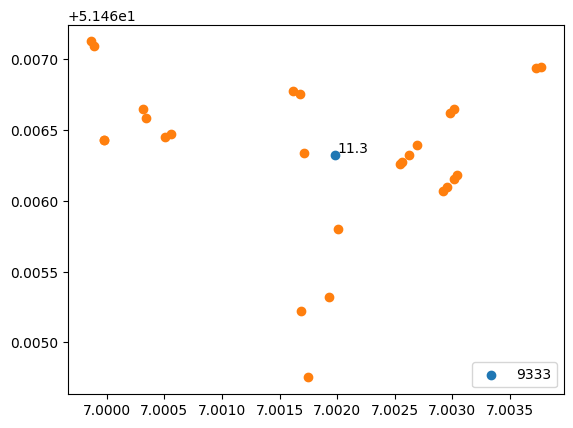

9855


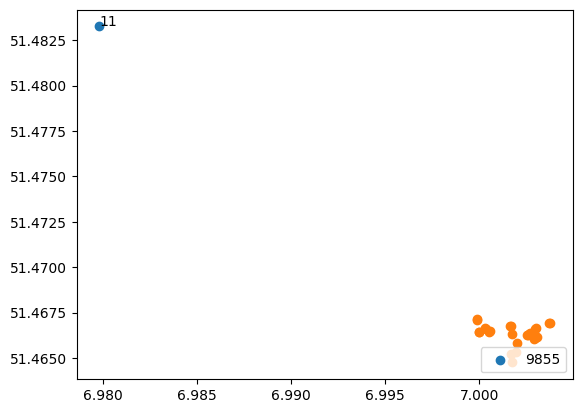

9673


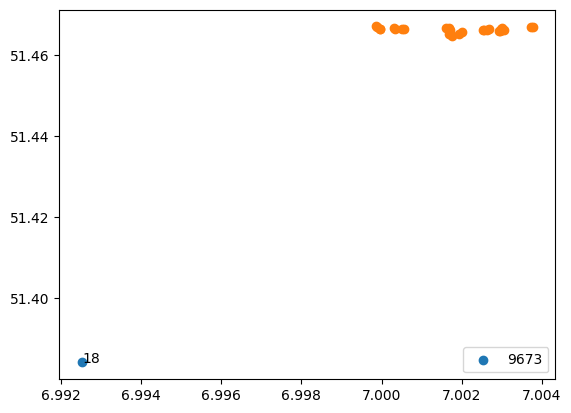

In [95]:
increased = 0
decreased = 0
unchanged = 0

for qid_dict in qids_with_neighbors:    
    qid=list(qid_dict.keys())[0]
    print(qid)
    price_difference = original_price[qid] - optimal_price[qid]
    
    if price_difference > 0:
        decreased += 1
    elif price_difference < 0:
        increased += 1
    else:
        unchanged += 1
        
    plt.scatter(x=test_data[test_data.Qid==qid].Laenge, y=test_data[test_data.Qid==qid].Breite, label=qid)
    plt.scatter(test_data[test_data.Qid.isin(list(qids_with_neighbors[0].values())[0])].Laenge, test_data[test_data.Qid.isin(list(qids_with_neighbors[0].values())[0])].Breite)
    plt.annotate(optimal_price[qid], (test_data[test_data.Qid==qid].Laenge+2e-5, test_data[test_data.Qid==qid].Breite+2e-5))

    plt.legend(loc='lower right')
    plt.show()

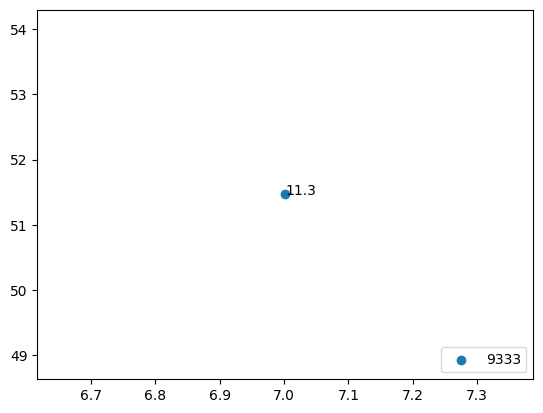

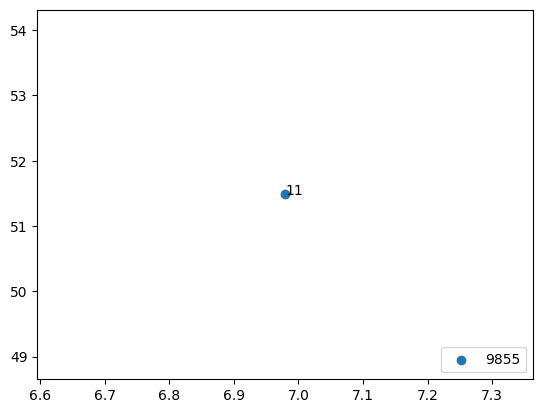

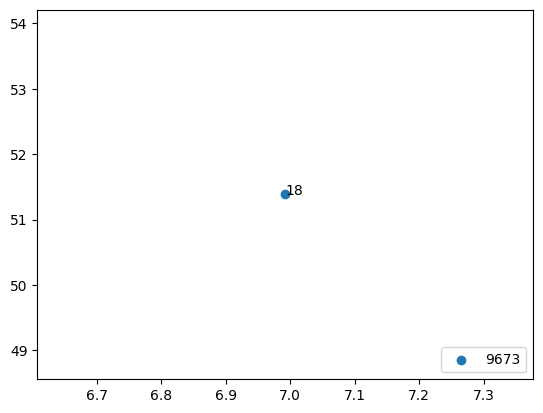

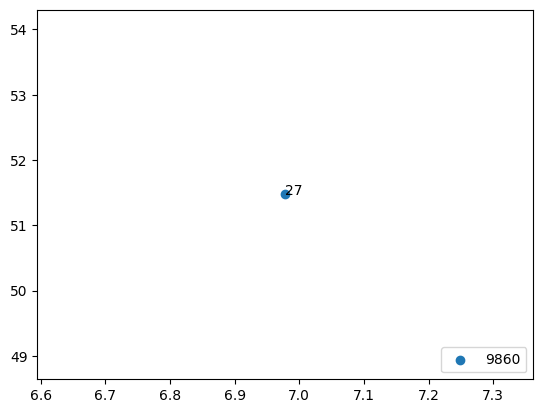

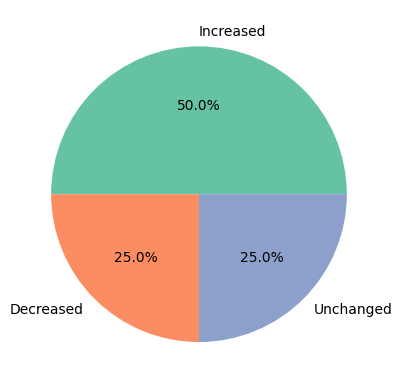

Increased: 2 50.0%
Decreased: 1 25.0%
Unchanged: 1 25.0%


In [96]:
increased = 0
decreased = 0
unchanged = 0

for qid in qids:    
    price_difference = original_price[qid] - optimal_price[qid]
    
    if price_difference > 0:
        decreased += 1
    elif price_difference < 0:
        increased += 1
    else:
        unchanged += 1
        
    plt.scatter(x=test_data[test_data.Qid==qid].Laenge, y=test_data[test_data.Qid==qid].Breite, label=qid)

#     plt.scatter(x=test_data[test_data.Qid==qid].Laenge+0.001, y=test_data[test_data.Qid==qid].Breite+0.02, c='black')
    plt.annotate(optimal_price[qid], (test_data[test_data.Qid==qid].Laenge+2e-5, test_data[test_data.Qid==qid].Breite++2e-5))

    plt.legend(loc='lower right')
    plt.show()


percentage = [increased, decreased, unchanged]
label = ['Increased', 'Decreased', 'Unchanged']
plt.pie(percentage, labels=label, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.show()
    
total_prices = len(original_price)

percentage_increased = (increased / total_prices) * 100
percentage_decreased = (decreased / total_prices) * 100
percentage_unchanged = (unchanged / total_prices) * 100

print(f"Increased: {increased} {percentage_increased}%")
print(f"Decreased: {decreased} {percentage_decreased}%")
print(f"Unchanged: {unchanged} {percentage_unchanged}%")

In [ ]:
## fig, ax = plt.subplots()
percentage = [increased, decreased, unchanged]
label = ['Increased', 'Decreased', 'Unchanged']
plt.pie(percentage, labels=label, autopct='%1.1f%%')
plt.show()

In [118]:
qid=106050

In [122]:
distance=pd.read_csv('data/distances/test.csv')

In [149]:
distance_qid=distance[distance.Qid_1==qid].sort_values(by='distance')
distance_qid

,Qid_1,Qid_2,Laenge_1,Breite_1,Laenge_2,Breite_2,distance
172965,106050,106050,11.424496,48.142597,11.424496,48.142597,0.000000
172966,106050,106051,11.424496,48.142597,11.424490,48.142622,0.002755
172962,106050,105111,11.424496,48.142597,11.424460,48.142635,0.004968
172985,106050,348940,11.424496,48.142597,11.424252,48.142534,0.019415
172978,106050,111701,11.424496,48.142597,11.424284,48.142473,0.020935
...,...,...,...,...,...,...,...
172927,106050,738420,11.424496,48.142597,11.418060,48.141961,0.482787
172928,106050,738421,11.424496,48.142597,11.417943,48.141945,0.491618
182869,106050,735653,11.424496,48.142597,11.422578,48.147792,0.594861
182870,106050,735654,11.424496,48.142597,11.422651,48.147816,0.596266


In [156]:
neighbourhood = {106050 : distance_qid[distance_qid['Qid_1']==qid].Qid_2.values}

In [157]:
neighbourhood

{106050: array([106050, 106051, 105111, 348940, 111701, 111702, 820331, 111703,
        820333, 111713, 111712, 111714, 106856, 106857, 106858, 108824,
        107765, 106855, 751795, 109805, 104595, 104455, 111087, 111711,
         96682,  96683, 104448, 104447, 104965, 104966, 104608, 104609,
         87739,  86739,  96482,  96150,  96483,  96151, 100097,  97902,
         86738, 106061,  86737,  86938, 106209, 109804,  88970, 105854,
         88967,  97900,  88968,  88969, 105303,  97901, 398152,  97903,
        100100, 104815, 100099, 100098,  98232, 396629, 396630, 802280,
        397087, 847823,  97191, 761279,  97192, 106844, 796912, 796911,
        107572, 107949, 738420, 738421, 735653, 735654, 397097])}

In [167]:
neighbours_coords = distance_qid[distance_qid.Qid_2.isin(neighbourhood[qid][1:])][["Laenge_2", "Breite_2"]].values.T

In [183]:
list(map(list, zip(*neighbours_coords)))

[11.4244902886, 48.1426216111]

In [194]:
qid

106050

In [244]:
distance_2018_new[distance_2018_new.Qid1==qid].Qid2.values
old_neighbors=data[(data.Qid.isin(distance_2018_new[distance_2018_new.Qid1==qid].Qid2.values))&(data.GJ==2018)][["Laenge", "Breite"]]
# old_neighbors.values.T

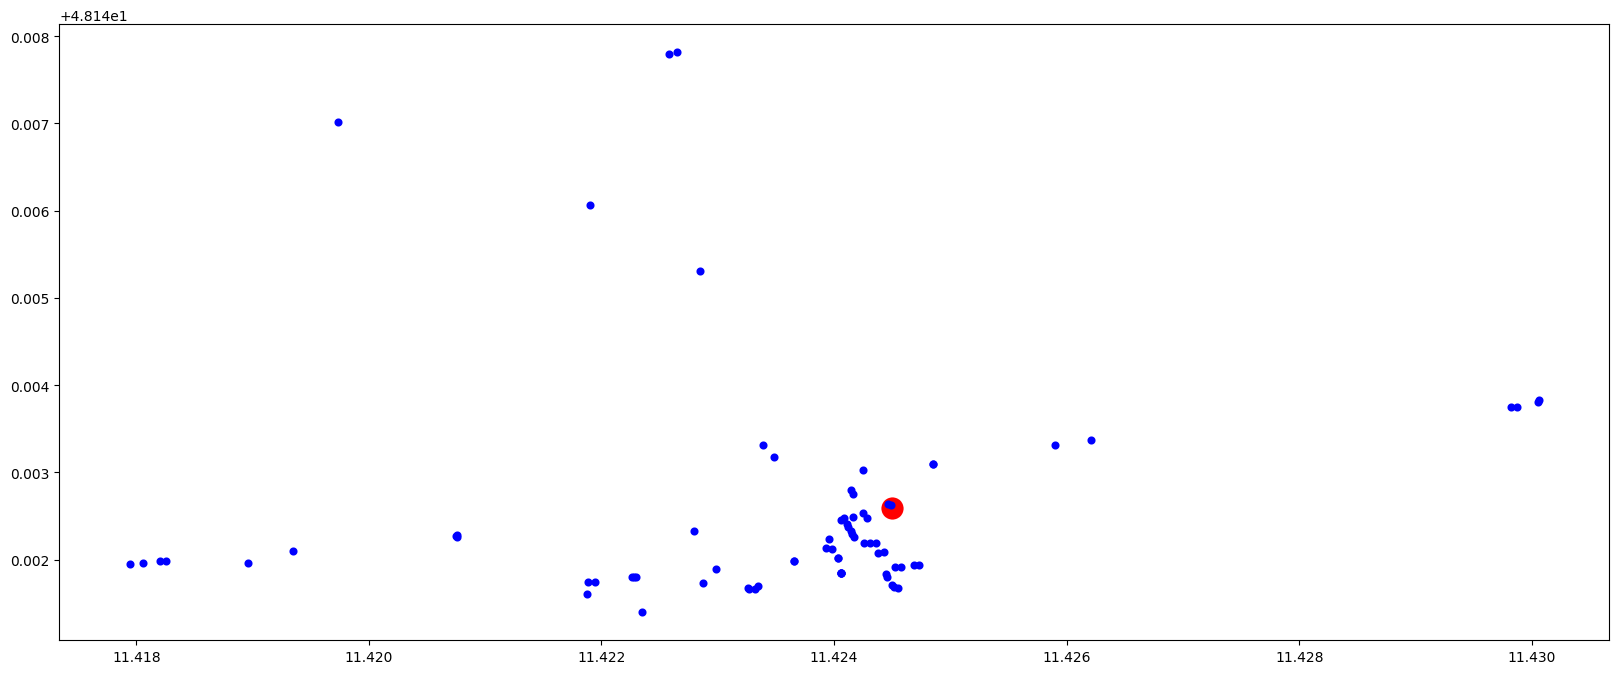

In [265]:
self_coords = [distance_qid[["Laenge_1", "Breite_1"]].values.T[0][0], distance_qid[["Laenge_1", "Breite_1"]].values.T[1][0]]
neighbours_coords = distance_qid[distance_qid.Qid_2.isin(neighbourhood[qid][1:])][["Laenge_2", "Breite_2"]].values.T

fig, ax = plt.subplots(figsize=(20, 8))
ax.scatter(self_coords[0],self_coords[1], linewidths=10, c='red')
for i, neighbour in enumerate(list(map(list, zip(*neighbours_coords)))):
    ax.scatter(x=neighbour[0], y=neighbour[1], s=8, c='blue', linewidths=3)
plt.show()

In [266]:
self_coords[0]

11.4244961107

In [267]:
neighbour[0]+2*abs(self_coords[0]-neighbour[0].min())

11.4292595204

11.4244902886 48.1426216111


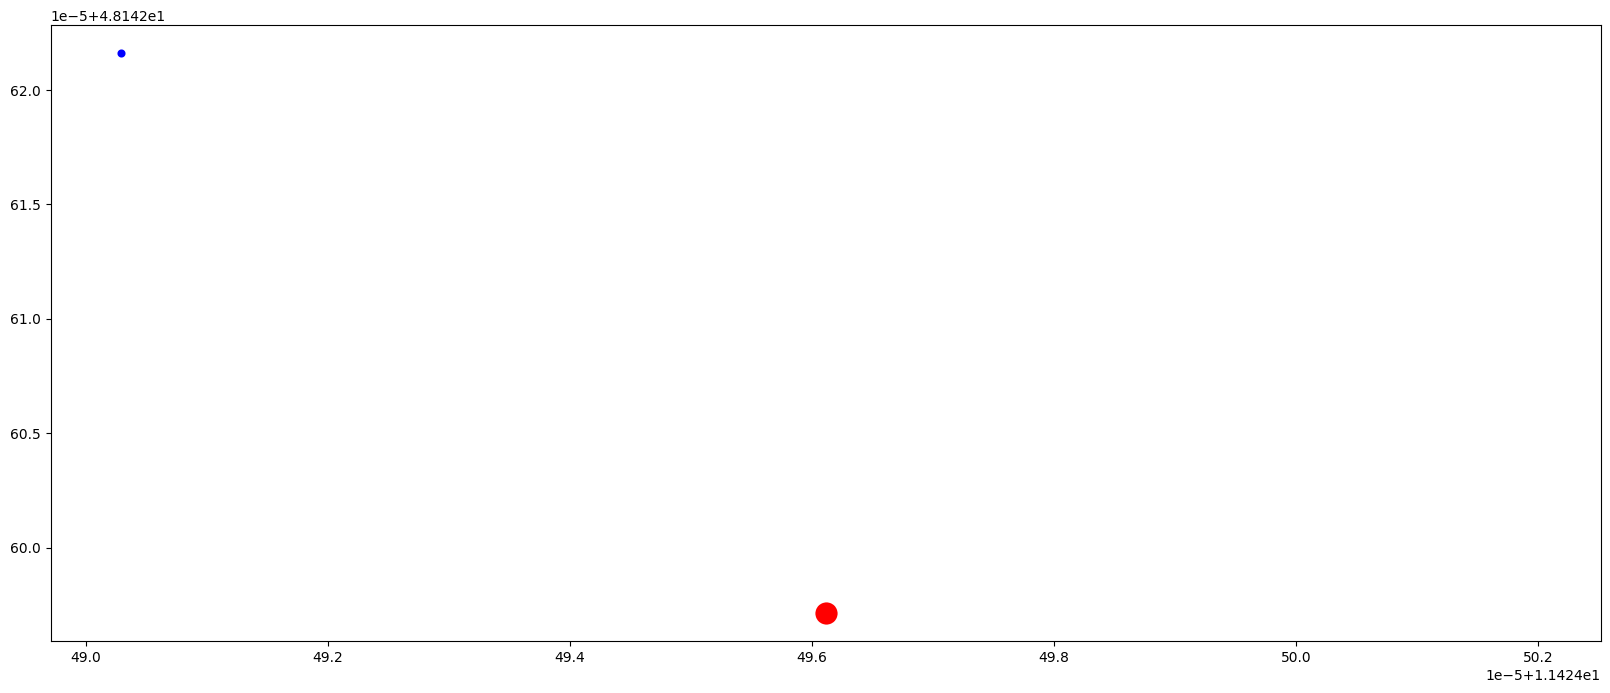

In [273]:
self_coords = [distance_qid[["Laenge_1", "Breite_1"]].values.T[0][0], distance_qid[["Laenge_1", "Breite_1"]].values.T[1][0]]
old_neighbors=data[(data.Qid.isin(distance_2018_new[distance_2018_new.Qid1==qid].Qid2.values))&(data.GJ==2018)][["Laenge", "Breite"]].values[1:].T

fig, ax = plt.subplots(figsize=(20, 8))
ax.scatter(self_coords[0],self_coords[1], linewidths=10, c='red')
for i, neighbour in enumerate(list(map(list, zip(*old_neighbors)))):
    print(neighbour[0], neighbour[1])
    ax.scatter(x=neighbour[0], y= neighbour[1], s=8, c='blue', linewidths=3)
ax.scatter(x=neighbour[0]+2*abs(self_coords[0]-neighbour[0].min()), y= neighbour[1], s=8, c='w', linewidths=3)
plt.show()

In [170]:
cmap_red = plt.get_cmap('Reds_r')  
cmap_green = plt.get_cmap('Greens')
 


if len(neighbours_coords[0]):

    diff = abs(self_coords[1]-neighbours_coords[1].max())/14
    color = (qid_data[k].Optimal_preis-qid_data[k].Preis)/qid_data[k].Preis*100

    fig, ax = plt.subplots(figsize=(20, 8))
    ax.scatter(*self_coords, linewidths=10, c=[cmap(norm(color[0]))] )
    ax.annotate(xy=(self_coords[0], self_coords[1]+diff), text=int(neighbourhood[qid][0]), weight='bold', size=11)


    for i, neighbour in enumerate(list(map(list, zip(*neighbours_coords)))):
        if color[i+1] > 0:
            cmap = plt.get_cmap('Greens')
            norm = plt.Normalize(0, 20)
        else:
            cmap = plt.get_cmap('Reds_r')
            norm = plt.Normalize(-20, 0)
        ax.scatter(x=neighbour[0], y= neighbour[1], s=80, c=[cmap(norm(color[i+1]))], linewidths=3)


    ax.scatter(x=neighbour[0]+2*abs(self_coords[0]-neighbours_coords[0].min()), y=neighbour[1], s=80, c='w', linewidths=3)
    ax.set_facecolor("white")

    sm = plt.cm.ScalarMappable(cmap=cmap_red, norm=plt.Normalize(-100, 0))
    sm.set_array([])  
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Price decreased')  


    sm = plt.cm.ScalarMappable(cmap=cmap_green, norm=plt.Normalize(0, 100))
    sm.set_array([])  
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Price increased')  
    ax.set_xticks([]) 
    ax.set_yticks([]) 

    plt.show()

NameError: name 'qid_data' is not defined